In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN warnings

import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Only show errors, not info/warnings
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from tqdm.keras import TqdmCallback
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [17]:
class Autoencoder(keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder: Sequential model with layers [8, 5, 3] output units
        self.encoder = Sequential([
            Dense(8, activation='relu'),
            Dense(5, activation='relu'),
            Dense(3, activation='relu')
        ])
        
        # Decoder: Sequential model with layers [5, 8, 9] output units
        self.decoder = Sequential([
            Dense(5, activation='relu'),
            Dense(8, activation='relu'),
            Dense(9, activation='sigmoid')  
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

Load dataset 'shuttle', train-test split and normalize the dataset

In [18]:
shuttle_data = loadmat('shuttle.mat')

X = shuttle_data['X']
y = shuttle_data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=.5, 
    random_state=42
    )
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

contamination = np.sum(y_train) / len(y_train)
print(f"Calculated contamination: {contamination:.4f}")

z_score = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
z_aggr = np.max(np.abs(z_score), axis=1)

threshold = np.quantile(z_aggr, 1 - contamination)
print(f"Threshold: {threshold:.4f}")

Calculated contamination: 0.0721
Threshold: 2.9172


In [19]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_test, X_test),
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

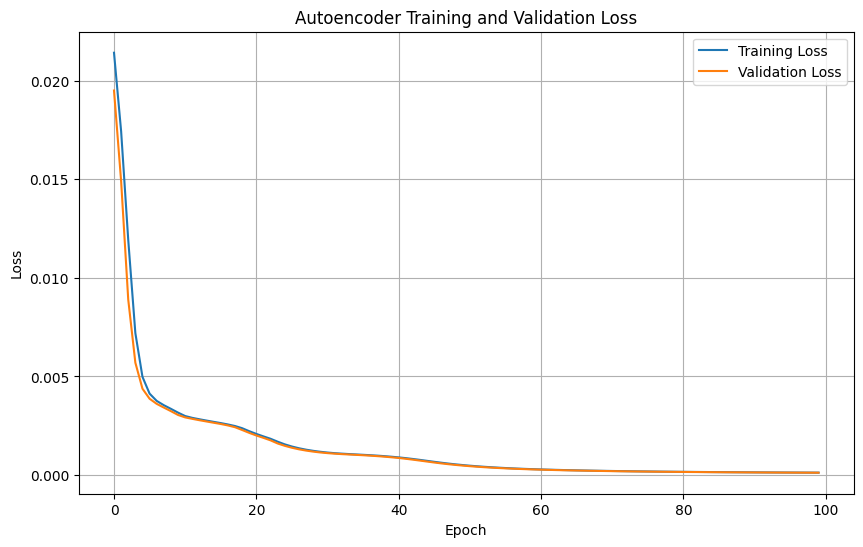

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
X_train_pred = autoencoder.predict(X_train)
train_reconstruction_error = np.mean(np.square(X_train - X_train_pred), axis=1)

# Get reconstruction errors for testing data
X_test_pred = autoencoder.predict(X_test)
test_reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)

# Classify
y_train_pred = (train_reconstruction_error > threshold).astype(int)
y_test_pred = (test_reconstruction_error > threshold).astype(int)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

print(f"Training Balanced Accuracy: {train_balanced_acc:.4f}")
print(f"Testing Balanced Accuracy: {test_balanced_acc:.4f}")

768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step
Training Balanced Accuracy: 0.5000
Testing Balanced Accuracy: 0.5000
